# INTRODUCCIÓN

##### En este ejercicio vamos a explorar la selección de variables y reducción dimensional, aplicando la técnica de PCA y evaluando su resultado e impacto en el modelo.

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

RANDOM_SEED = 42
n_dim = 64

plt.style.use('bmh')

In [44]:
df = pd.read_csv('./FraudInputDatav2.csv', encoding = "utf-16") #leemos el fichero de datos, codificado en utf-16
df.head()

,ID,ac,ab,N1,NCE,pm,Value,Credit,Channel,Product,...,N5_Accounts_Card,N5_Devices_Account,N5_Names_Account,N5_CEP_Account,N5_Cards_Account,N5_Cards_Device,Fraud,random,sample,FraudStr
0,1,0.445878,-0.359697,0,0,credit_card,-0.258301,0,CD,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.027303,train,Good
1,2,-0.782197,-0.632741,0,0,credit_card,-0.258301,0,CE,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.028333,train,Good
2,3,0.298404,0.927510,0,0,credit_card,-0.275540,0,CD,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.008819,check,Good
3,4,-0.664740,2.472159,0,0,credit_card,-0.274538,1,CE,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.038630,train,Good
4,5,-0.223625,-0.617138,0,0,credit_card,-0.218079,0,CD,CA,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.000657,train,Good


In [45]:
#vamos a linealizar las variables categoricas usando un one-hot-enconding
#para eso el primer paso es encontrar todas las variables categoricas, seran aquellas que tengan el tipo object
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()
#como podeis ver el dataset tiene 8 variables categoricas. No linealizaremos FraudStr y sample ya que serán borradas posteriormente

,pm,Channel,Product,sl,le,Routing,sample,FraudStr
0,credit_card,CD,F,0,YYY,mobile gateway,train,Good
1,credit_card,CE,F,0,YYY,fixed,train,Good
2,credit_card,CD,CB,EU,YYY,fixed,check,Good
3,credit_card,CE,CB,0,YYY,pop,train,Good
4,credit_card,CD,CA,0,YYY,fixed,train,Good


In [46]:
##realizamos la codificación
df_encoding = pd.get_dummies(obj_df, columns=['pm','Channel','Product','sl','le','Routing'])
df_encoding.head()
#como podeis ver se ha creado una columna por cada valor de las variables categoricas.
#Por ejemplo la variable payment ha sido convertida a 4 variables numéricas

,sample,FraudStr,pm_clicknbuy,pm_credit_card,pm_payease,pm_paypal,pm_store_credit,Channel_A,Channel_BA,Channel_BB,...,Routing_aolpop,Routing_aolproxy,Routing_cache proxy,Routing_fixed,Routing_international proxy,Routing_mobile gateway,Routing_none,Routing_pop,Routing_regional proxy,Routing_satellite
0,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,check,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [47]:
#obtenemos el resto de variables para concatenarlo en el df de trabajo
num_df = df.select_dtypes(include=['int64','float64']).copy()
df_num = pd.concat([df_encoding,num_df], axis=1).drop('ID',1).drop('random', 1).drop('sample', 1).drop('FraudStr', 1) #aprovecho para quitar columnas no necesarias


### Como puede verse esta variable puede llegar a ser muy discriminante. Vamos a estudiar el resto de variables

In [48]:
#borramos columnas con una distribución uniforme entre fraude y no fraude
df_features=df_num.drop(['Channel_BA','Channel_BB','Channel_BC','Channel_CA','Channel_D','Channel_E','Product_A','Product_B','Product_CA','Product_D','Product_E','Product_G','Product_Z','sl_JP','sl_NZ','Routing_0','Routing_aoldialup','Routing_aolpop','Routing_aolproxy','Routing_cache proxy','Routing_pop','Routing_regional proxy','Routing_satellite','ac','ab','N1','NCE','QualifiedGood','Risk_Email','Risk_CEP','Risk_Card','Risk_FistName','Risk_LastName','Risk_IP_Class','Risk_IP_Domain','Risk_IP_Carrier'],axis=1)


In [49]:
tt = df_features.describe().transpose()
tt[(tt['max']>1) & (tt['min']< -1)]

,count,mean,std,min,25%,50%,75%,max
Risk_Item,62763.0,-1.389215e-14,0.972078,-2.935098,-0.301426,0.000000,0.257719,4.407077
Risk_ProductType,62763.0,3.128379e-15,0.882261,-6.053142,-0.038964,0.000000,0.326596,8.362492
Risk_Provider,62763.0,1.202075e-14,0.998916,-6.767770,-0.310101,-0.187156,0.046344,8.439375


In [50]:
columns_to_norm = ['Risk_Item','Risk_ProductType','Risk_Provider']

In [51]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df_features[columns_to_norm]=min_max_scaler.fit_transform(df_features[columns_to_norm])


In [52]:
tt = df_features.describe().transpose()
tt[(tt['max']>1) & (tt['min']< -1)]

,count,mean,std,min,25%,50%,75%,max


# CORRELACIÓN DE VARIABLES

#### EJEMPLO DE CLUSTERING CON PCA

In [53]:
# Estudiamos el resto de variables
y=df_features.Fraud
x=df_features.drop('Fraud',axis=1)

#### En este ejemplo para visualizarlo mejor vamos a trabajar con un PCA de 2 dimensiones. Aviso! en el ejercicio que hagais vosotros usar más dimensiones!

In [54]:
#PCA
n_dim = 2
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=n_dim, whiten=True)
sklearn_pca.fit(x)
features_pca = pd.DataFrame(data = sklearn_pca.transform(x))


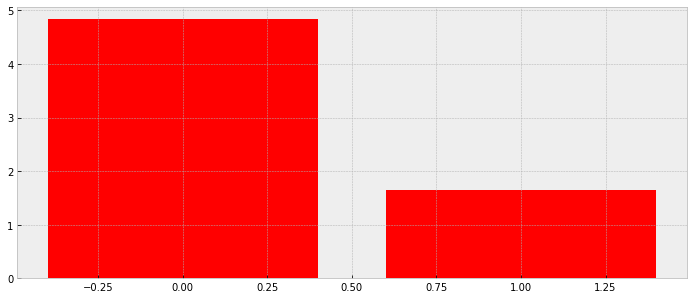

In [55]:
plt.figure(figsize=(12, 5))
rects1 = plt.bar(np.arange(n_dim),sklearn_pca.explained_variance_, color='r')


In [56]:
# nos quedaremos con las primeras 32 variables
features_pca2 = features_pca.values
features_pca2.shape

(62763, 2)

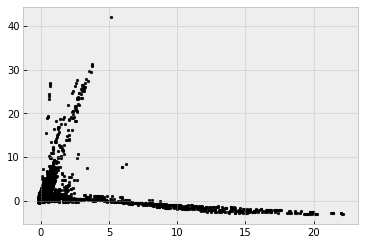

In [57]:
plt.scatter(features_pca2[:,0], features_pca2[:,1], c='black', s=7)

#### Vamos a aplicar un algoritmo sencillo de clustering. Si queréis podeis probar con otros algoritmos más potentes que este.
#### Lo primero, voy a buscar el número de clusters óptimos. Para ello, preparo un bucle para probar de 1 a 20 clusters, y observo la distancia de los puntos a su centro de cluster, como medida de rendimiento

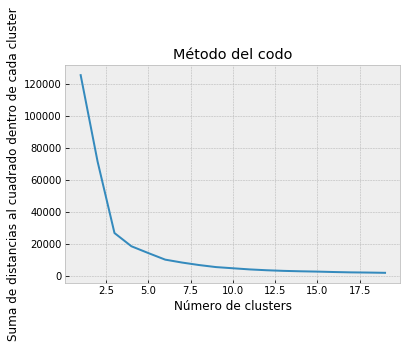

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

res = []
N_max=20
N_min=1
for i in range(N_min, N_max):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(features_pca2)
    # Obtenemos la suma de las distancias al cuadrado dentro de cada cluster
    res.append(kmeans.inertia_)

plt.plot(range(N_min, N_max), res)
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Suma de distancias al cuadrado dentro de cada cluster')
plt.show()

In [59]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(features_pca2)
#consigo los clusters que genera el algoritmo como un vector y lo uno todo en un mismo dataframe
Z = kmeans.predict(features_pca2)
x = np.transpose(features_pca2)
y = (df_features['Fraud'].values)
z= np.array([Z]).T
xx =np.hstack((x.T,np.array([y]).T))
all = np.hstack((xx,z))
alldf = pd.DataFrame(all)

In [60]:
alldf.head()
#columna 0: pca dim 1, columna 1: pca dim2, columna2: fraude/buena columna 3: cluster

,0,1,2,3
0,-0.117950,-0.112476,0.0,0.0
1,-0.122611,-0.171000,0.0,0.0
2,-0.099381,-0.102337,0.0,0.0
3,-0.114275,-0.084738,0.0,0.0
4,-0.109669,-0.147893,0.0,0.0


#### Vamos a realizar una visualización sencilla, donde separamos los datos en buenos y fraudulentos para cada cluster (TODO: esto que yo hago a mano puede automatizarse para cualquier número de clusters)

In [61]:
n_fraude = 2
n_cluster = 3
alldfgood0 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 0]
alldffraud0 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 0]
alldfgood1 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 1]
alldffraud1 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 1]
alldfgood2 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 2]
alldffraud2 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 2]
alldfgood3 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 3]
alldffraud3 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 3]
alldfgood4 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 4]
alldffraud4 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 4]
alldfgood5 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 5]
alldffraud5 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 5]

#### Si observais los datos, su estructura, vereis que hay clusters con solo fraude, solo buenos, y mezclados

In [62]:
alldffraud1.shape

(190, 4)

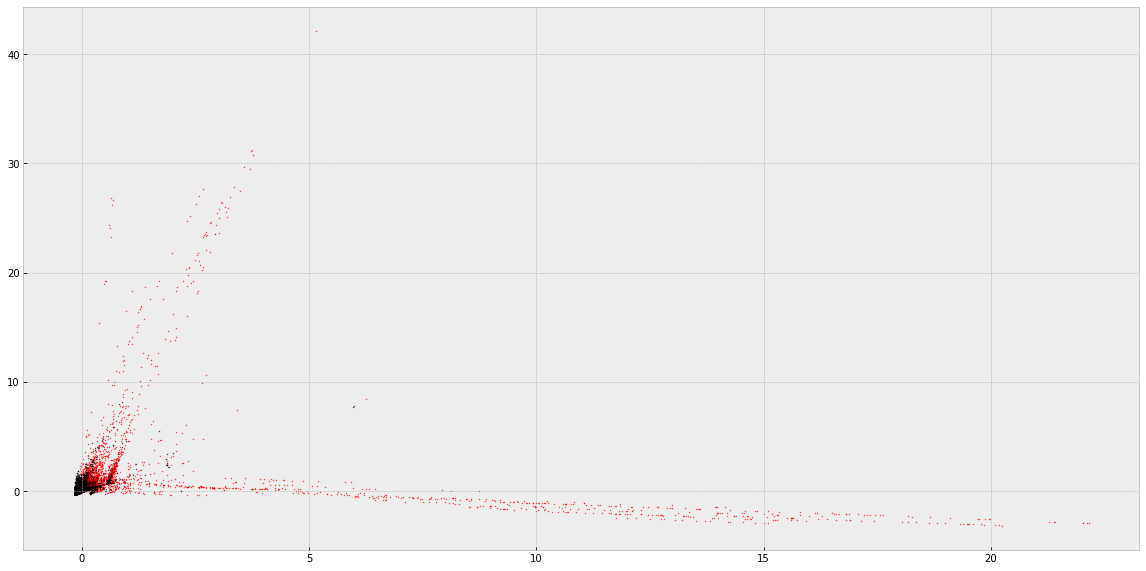

In [63]:
alldfgood = alldf.loc[alldf[2] == 0].values
alldffraud = alldf.loc[alldf[2] == 1].values
plt.figure(figsize=(20, 10))
plt.scatter(alldffraud[:,0], alldffraud[:,1],alpha = 0.5, c='red', s=1)
plt.scatter(alldfgood[:,0], alldfgood[:,1], alpha=0.5, c='black', s=1)


Text(0.5,1,'Valores para cluster 5')

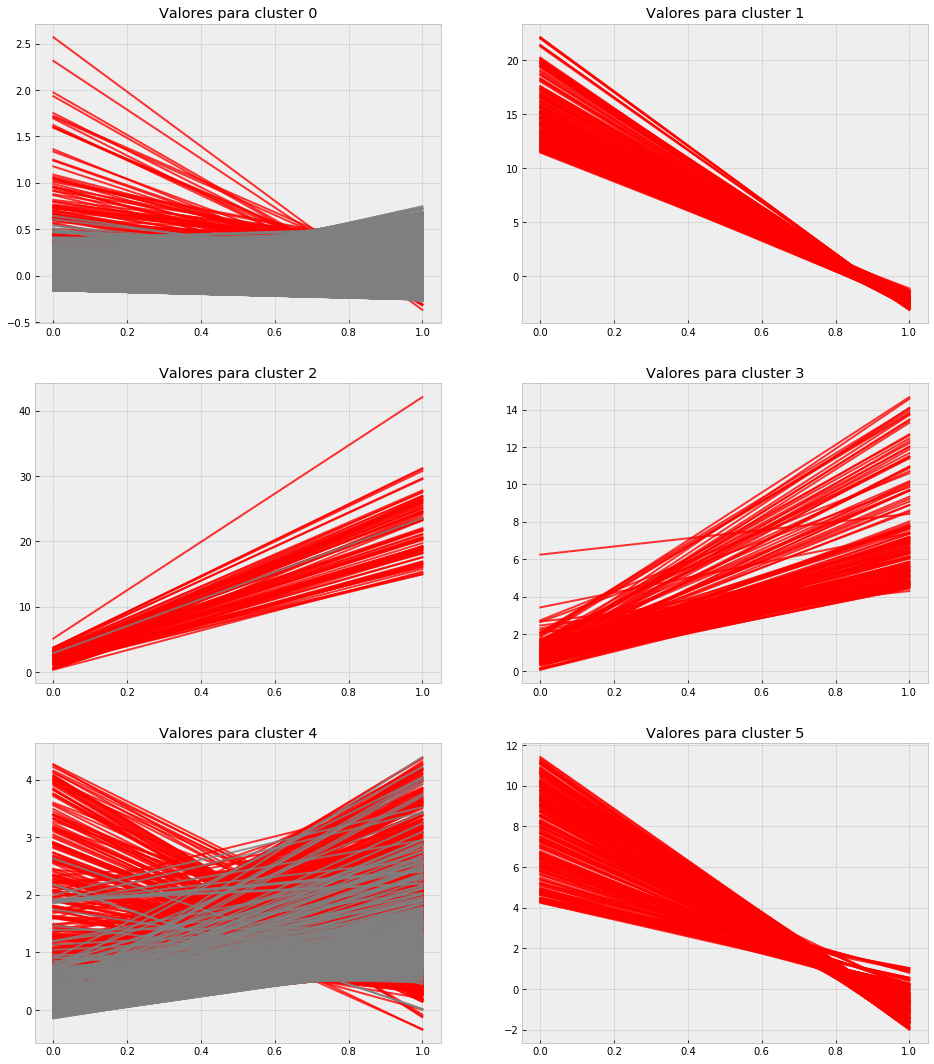

In [64]:
#tarda un poco en pintar toda la información. 
#Conviene que useis alpha, aunque tarde un poco más, marca la transparencia de los puntos. Si son opacos no lo vereis bien
plt.figure(figsize=(16, 32))
plt.subplot(5, 2, 1)
plt.plot(np.transpose(alldffraud0.values[:,0:n_fraude]), alpha=0.8,color='red')
plt.plot(np.transpose(alldfgood0.values[:,0:n_fraude]),alpha=0.8, color='grey')

plt.title("Valores para cluster 0")
plt.subplot(5, 2, 2)
#plt.plot(np.transpose(alldfgood1.values[:,0:n_fraude]),alpha=0.8, color='grey',linewidth=0.1)
plt.plot(np.transpose(alldffraud1.values[:,0:n_fraude]),alpha=0.8, color='red')
plt.title("Valores para cluster 1")
plt.subplot(5, 2, 3)
plt.plot(np.transpose(alldffraud2.values[:,0:n_fraude]),alpha=0.8, color='red')
plt.plot(np.transpose(alldfgood2.values[:,0:n_fraude]),alpha=0.8, color='grey')

plt.title("Valores para cluster 2")
plt.subplot(5, 2, 4)
plt.plot(np.transpose(alldffraud3.values[:,0:n_fraude]),alpha=0.8, color='red')
#plt.plot(np.transpose(alldfgood3.values[:,0:n_fraude]), alpha=0.8,color='grey')
plt.title("Valores para cluster 3")
plt.subplot(5, 2, 5)
plt.plot(np.transpose(alldffraud4.values[:,0:n_fraude]), alpha=0.8,color='red')
plt.plot(np.transpose(alldfgood4.values[:,0:n_fraude]), alpha=0.8,color='grey')

plt.title("Valores para cluster 4")
plt.subplot(5, 2, 6)
#plt.plot(np.transpose(alldfgood5.values[:,0:n_fraude]),alpha=0.8, color='grey')
plt.plot(np.transpose(alldffraud5.values[:,0:n_fraude]),alpha=0.8, color='red')
plt.title("Valores para cluster 5")

#### Ahora vamos a calcular la distancia de cada punto al centro de su cluster

In [65]:
kmeans.cluster_centers_

array([[-0.10230963, -0.0943944 ],
       [15.07882553, -2.2525973 ],
       [ 2.2756129 , 22.27347887],
       [ 1.10147712,  7.41556284],
       [ 0.48352178,  1.33699678],
       [ 7.92940663, -0.7475346 ]])

In [66]:
alldf['centers']=alldf[n_cluster]

In [67]:
cluster_number = alldf['centers'].values.astype('int64')

In [68]:
centers = kmeans.cluster_centers_

In [69]:
positions = alldf.iloc[:,0:n_fraude].values
positions

array([[-0.11795049, -0.11247619],
       [-0.1226111 , -0.17099972],
       [-0.09938139, -0.10233713],
       ...,
       [-0.07318942,  0.00233138],
       [-0.14453319, -0.20502445],
       [-0.11713769, -0.157783  ]])

In [70]:
d=np.sqrt(((positions-centers[cluster_number])**2).sum(axis=1)) #calculamos la distancia

In [71]:
alldf = pd.DataFrame(np.hstack((alldf.values,np.array([d]).T))) #añadimos la columna al dataset

In [72]:
alldf.head()

,0,1,2,3,4,5
0,-0.117950,-0.112476,0.0,0.0,0.0,0.023908
1,-0.122611,-0.171000,0.0,0.0,0.0,0.079250
2,-0.099381,-0.102337,0.0,0.0,0.0,0.008465
3,-0.114275,-0.084738,0.0,0.0,0.0,0.015376
4,-0.109669,-0.147893,0.0,0.0,0.0,0.054002


In [73]:
#volvemos a generar la separación en clusters y buenos/fraudulentos

alldfgood0 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 0][n_cluster+2]
alldffraud0 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 0][n_cluster+2]
alldfgood1 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 1][n_cluster+2]
alldffraud1 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 1][n_cluster+2]
alldfgood2 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 2][n_cluster+2]
alldffraud2 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 2][n_cluster+2]
alldfgood3 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 3][n_cluster+2]
alldffraud3 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 3][n_cluster+2]
alldfgood4 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 4][n_cluster+2]
alldffraud4 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 4][n_cluster+2]
alldfgood5 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 5][n_cluster+2]
alldffraud5 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 5][n_cluster+2]


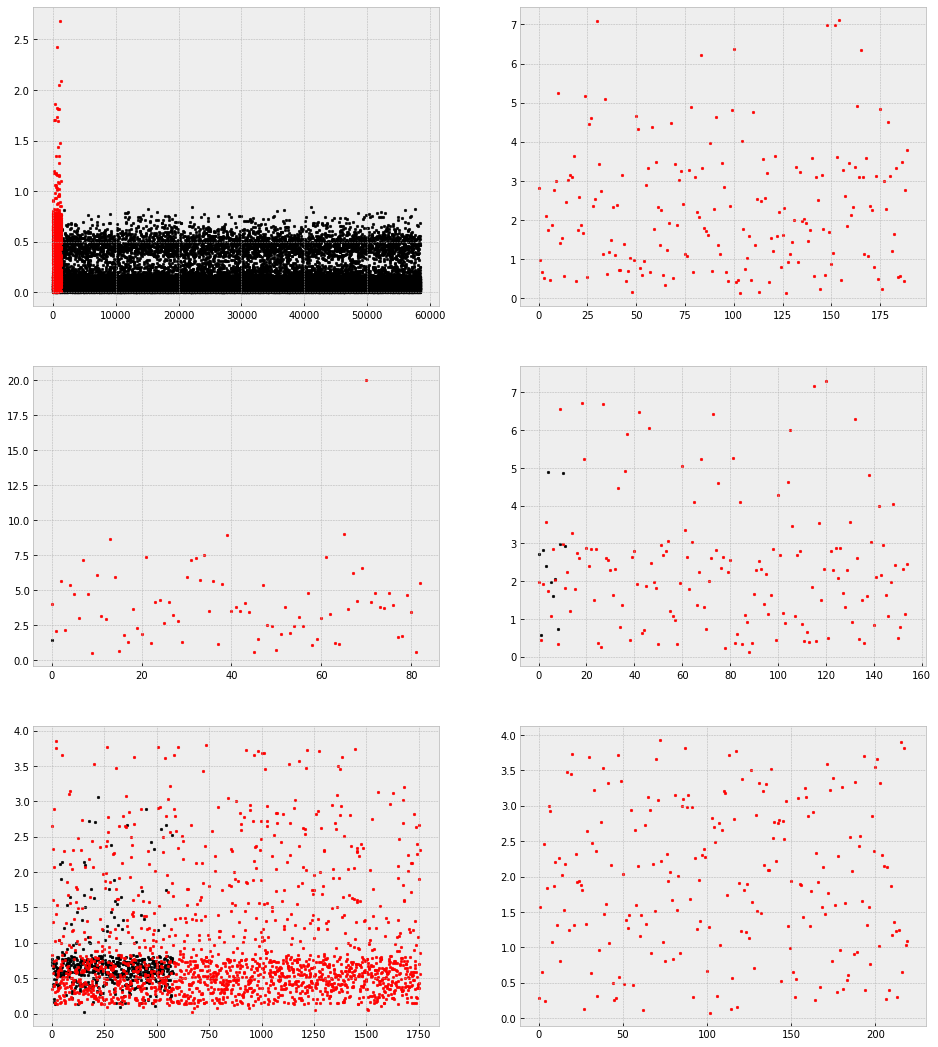

In [74]:
plt.figure(figsize=(16, 32))
plt.subplot(5, 2, 1)
plt.scatter( range(0,alldfgood0.size),alldfgood0, c='black', s=7)
plt.scatter( range(0,alldffraud0.size),alldffraud0, c='red', s=7)
plt.subplot(5, 2, 2)
plt.scatter( range(0,alldfgood1.size),alldfgood1, c='black', s=7)
plt.scatter( range(0,alldffraud1.size),alldffraud1, c='red', s=7)
plt.subplot(5, 2, 3)
plt.scatter( range(0,alldfgood2.size),alldfgood2, c='black', s=7)
plt.scatter( range(0,alldffraud2.size),alldffraud2, c='red', s=7)
plt.subplot(5, 2, 4)
plt.scatter( range(0,alldfgood3.size),alldfgood3, c='black', s=7)
plt.scatter( range(0,alldffraud3.size),alldffraud3, c='red', s=7)
plt.subplot(5, 2, 5)
plt.scatter( range(0,alldfgood4.size),alldfgood4, c='black', s=7)
plt.scatter( range(0,alldffraud4.size),alldffraud4, c='red', s=7)
plt.subplot(5, 2, 6)
plt.scatter( range(0,alldfgood5.size),alldfgood5, c='black', s=7)
plt.scatter( range(0,alldffraud5.size),alldffraud5, c='red', s=7)